In [1]:
import scipy.stats as stats 
import statsmodels.stats.api as sms
import numpy as np #linear algebra 
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv) 
import matplotlib.pyplot as plt #интерактивная визуализация 
import statsmodels.api as sm # regression fitting via matrices of regression design 
import statsmodels.formula.api as smf # data visualization, regression fitting 
from statsmodels.iolib.summary2 import summary_params # вывод результатов тестирования 
from statsmodels.iolib.summary2 import summary_col # вывод результатов тестирования 
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 
import io #преобразование строк в данные
import seaborn as sns 
import re #библиотека для работы с регулярными выражениями
import statsmodels.stats.diagnostic as dg

## Анализ датасета "Insurance"
$age$ - возраст
\
$sex$ - пол
\
$bmi$ - индекс массы тела (величина, позволяющая оценить степень соответствия массы человека и его роста, идеальным считаются значения 18.5 - 24.9)
\
$children$ - количество детей, охваченных медицинским страхованием
\
$smoker$ - курящий/не курящий
\
$region$ - регион проживания
\
$charges$ - индивидуальные медицинские расходы, оплачиваемые медицинским страхованием

In [2]:
df  =  pd.read_csv('https://raw.githubusercontent.com/PomoshnikovV/Econometrics_MGIMO/main/insurance.csv') 

In [3]:
df['smoker']=df.apply(lambda x: 1 if x['smoker'] == 'yes' else 0, axis=1)
df['sex']=df.apply(lambda x: 1 if x['sex'] == 'female' else 0, axis=1)
df['charges']=df['charges']
df

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,northwest,10600.54830
1334,18,1,31.920,0,0,northeast,2205.98080
1335,18,1,36.850,0,0,southeast,1629.83350
1336,21,1,25.800,0,0,southwest,2007.94500


### Какие существуют типы медицинской страховки?
HMO — health maintenance organizations. Стоимость медицинской страховки в США этого типа самая низкая. А все из-за очень ограниченного количества врачей и лечебных учреждений, которые вы можете посещать. Вы должны будете лечиться в заведениях одной сети, и у вас будет основной врач-терапевт, который будет выдавать направления к другим специалистам. Покрытие не включает услуги, оказываемые вне сети, кроме случаев оказания экстренной медицинской помощи. 

PPO — preferred provider organizations. Сеть учреждений все так же присутствует, однако она гораздо шире. Лечиться вы можете как в учреждениях сети, так и вне её (но в сети условия будут куда более выгодными). Также вам не нужно брать направление к специалистам, они примут вас по страховке и без него. Купить медицинскую страховку в США такого типа обойдется куда дороже, чем все остальные. 

Существуют также другие, менее популярные типы страховок. Point-of-service (POS) предполагает, что, используя услуги врачей и больниц из сети, вы будете платить меньше. Exclusive Provider Organization (EPO) — то же самое, что и HMO, только без основного врача и обязательных направлений к специалистам.

### Из-за того, что страховки в США различаются по стоимости, на графике ниже можно заметить, что данные расположены как бы "по уровням". Большинство пользуется страховкой по самой низкой цене

Подогнанная прямая


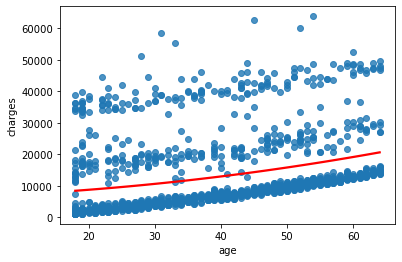

In [4]:
sns.regplot(data = df ,  y = 'charges' ,  x = 'age' , order = 2, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая') 

### Наблюдается "возрастающая отдача" от возраста на траты на медицинскую страховку. Логично, чем старше становишься, тем у тебя больше изношены суставы, тем медленнее восстанавливается организм при травмах и, следовательно, больше трат приходится на медицинское страхование.

## Курить невыгодно. Те, кто курят, платят за мед страховку намного больше (см. график ниже)

Подогнанная прямая


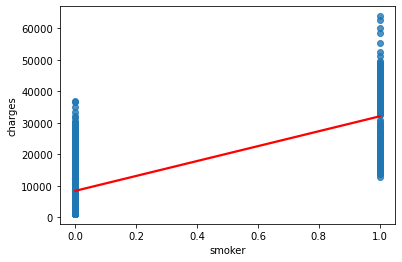

In [5]:
sns.regplot(data = df ,  y = 'charges' ,  x = 'smoker' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая') 

Подогнанная прямая


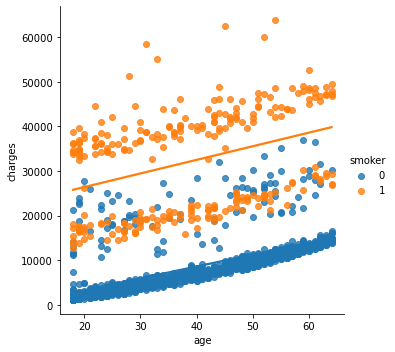

In [6]:
sns.lmplot(data = df ,  y = 'charges' ,  x = 'age' , order = 1, ci = None ,  hue='smoker') 
print('Подогнанная прямая') 

## Пухлым тоже не особо выгодно быть (см. график ниже) - предварительный вывод, пока что непонятно, действительно ли есть зависимость между bmi и charges

Подогнанная прямая


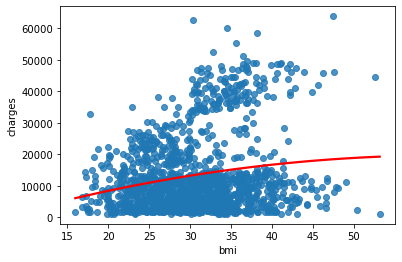

In [7]:
sns.regplot(data = df ,  y = 'charges' ,  x = 'bmi' , order = 2, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая')

### Однако на данном графике наблюдается гетероскедастичность

## Важно отметить, что чем старше человек, тем больше в среднем детей он имеет (до определенного возраста), которые при этом вписаны в страховку. Однако наблюдается "убывающая отдача", т.к. чем старше мы становимся, тем меньше вероятность, что родится новый ребенок, а уже повзрослевшие дети достигают совершеннолетия и имеют уже собственную мед страховку. (вывод сделан без оценки t набл., дальше проверим, действительно ли данный тезис является верным)

Подогнанная прямая


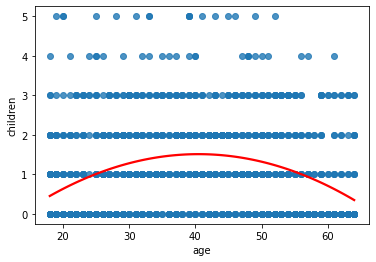

In [8]:
sns.regplot(data = df ,  y = 'children' ,  x = 'age' , order = 2, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая') 

Подогнанная прямая


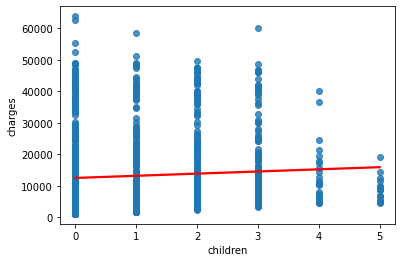

In [9]:
sns.regplot(data = df ,  y = 'charges' ,  x = 'children' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая') 

## Надо будет проверить, действительно ли на юго-востоке зарабатывают больше

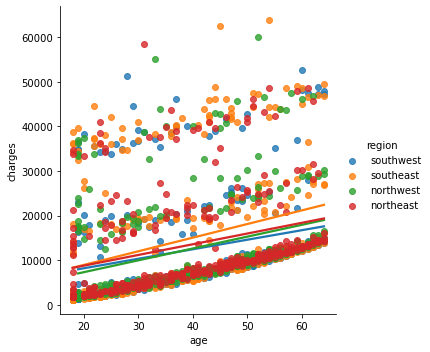

In [10]:
sns.lmplot(data=df, y='charges',x='age', ci=None, hue='region')

## Зависимость трат на страховку в зависимости от пола пока что не очевидна (см. графики ниже)

Подогнанная прямая


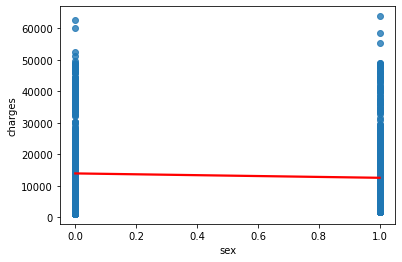

In [11]:
sns.regplot(data = df ,  y = 'charges' ,  x = 'sex' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая')

Подогнанная прямая


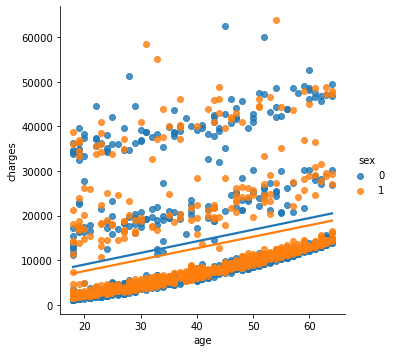

In [12]:
sns.lmplot(data = df ,  y = 'charges' ,  x = 'age' , order = 1, ci = None ,  hue='sex') 
print('Подогнанная прямая') 

## Спецификация модели:
$$
charges = \beta_0 + \beta_1*age +\beta_2*age^2 +\beta_3*bmi + \beta_4*bmi^2 + \beta_5*children + \beta_6*smoker + \beta_7*sex
$$

In [13]:
fitted = smf.ols(formula = 'charges~age+I(age**2)+bmi+I(bmi**2)+children+smoker+sex',  data = df ).fit() 
# коэффициенты с округлением 
fitted.params.round(3) 

Intercept     -13890.629
age              -57.845
I(age ** 2)        3.960
bmi              788.787
I(bmi ** 2)       -7.451
children         642.427
smoker         23857.990
sex              137.073
dtype: float64

In [14]:
fitted.summary(alpha=0.05).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.389e+04,3504.950,-3.963,0.000,-2.08e+04,-7014.795
age,-57.8446,80.970,-0.714,0.475,-216.688,100.999
I(age ** 2),3.9596,1.010,3.921,0.000,1.978,5.941
bmi,788.7872,207.180,3.807,0.000,382.352,1195.223
I(bmi ** 2),-7.4509,3.254,-2.289,0.022,-13.835,-1.066
children,642.4273,143.440,4.479,0.000,361.033,923.821
smoker,2.386e+04,409.825,58.215,0.000,2.31e+04,2.47e+04
sex,137.0732,331.080,0.414,0.679,-512.422,786.568


In [15]:
print('R^2 = ', round(fitted.rsquared,4))

R^2 =  0.7535


In [16]:
print('R2adj = ', 1 - (1-fitted.rsquared)*(len(df)-1)/(len(df)-7-1))

R2adj =  0.752217296820417


### Согласно $R^2=0.7535$ и $R^2_{adj}=0.7522$ регрессоры довольно неплохо описывают модель

## Проверим модель на гетероскедастичность:

In [17]:
df['resid']=fitted.resid
df['resid2']=df['resid']**2

Подогнанная прямая


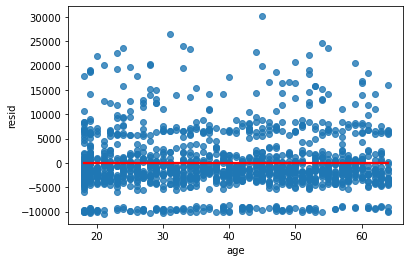

In [18]:
sns.regplot(data = df ,  y = 'resid' ,  x = 'age' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая')


#### выглядит, как идеальный пример гомоскедастичности

Подогнанная прямая


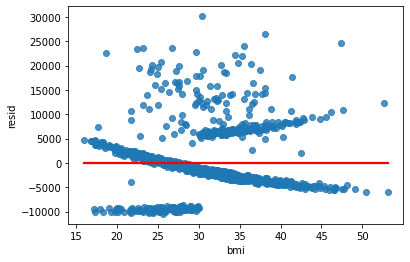

In [19]:
sns.regplot(data = df ,  y = 'resid' ,  x = 'bmi' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая')

#### выглядит, как гетероскедастичность, но до конца непонятно

Подогнанная прямая


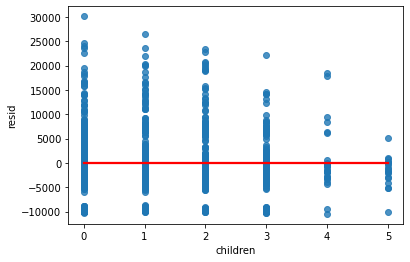

In [20]:
sns.regplot(data = df ,  y = 'resid' ,  x = 'children' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая')

#### похоже на гетероскедастичность - чем больше детей вписано в страховку, тем ниже разброс ошибки

Подогнанная прямая


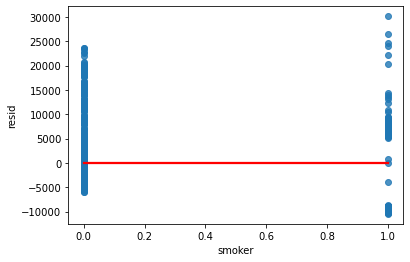

In [21]:
sns.regplot(data = df ,  y = 'resid' ,  x = 'smoker' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая')

#### опять похоже на гетероскедастичность

### На первый взгляд точно непонятно, наблюдается гетероскедастичность или гомоскедастичность. Проведем "Тест Уайта" (Breusch Pagan test)

$$e_i = y_i - \hat{y}_i$$
$$
e_i^2 = \gamma_0 + \gamma_1*age+\gamma_2*I(age**2)+\gamma_3*bmi+\gamma_4*bmi^2+\gamma_5*children+\gamma_6*smoker+\gamma_7*sex
$$
#### Гипотеза о характере зависимости дисперсии ошибок от факторов регресси:

$$
H_0: \gamma_1=\gamma_2=\gamma_3=\gamma_4=\gamma_5=\gamma_6=\gamma_7=0
$$
$$
H_1:  \gamma_1^2+\gamma_2^2+\gamma_3^2+\gamma_4^2+\gamma_5^2+\gamma_6^2>0
$$

In [22]:
fitted_TestWhite = smf.ols(formula = 'resid2~age+I(age**2)+bmi+I(bmi**2)+children+smoker+sex',  data = df ).fit() 
# коэффициенты с округлением 
fitted_TestWhite.params.round(2) 

Intercept      94183121.55
age               -5559.12
I(age ** 2)        -150.85
bmi            -4953779.28
I(bmi ** 2)       81788.47
children        1002114.68
smoker         57786499.14
sex             2921579.45
dtype: float64

In [23]:
print('n*R^2 = ',len(df)*fitted_TestWhite.rsquared)

n*R^2 =  122.0987884151263


In [24]:
print('Hi^2 = ',stats.chi2.ppf(1-0.0001,7))

Hi^2 =  29.87750390922517


## Несмотря на кажущуюся гомоскедастичность, тест Уайта указывает на гетероскедастичность. $n*R_0 > \chi^2$ -> принимается гипотеза $H_1$

## Следовательно, нужно получить состоятельные $t_{набл}$ в первоначальной регрессии

In [25]:
fitted = smf.ols(data=df, formula='charges~age+I(age**2)+bmi+I(bmi**2)+children+smoker+sex').fit(cov_type='HC3')
fitted.summary(alpha=0.05).tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.389e+04,3863.488,-3.595,0.000,-2.15e+04,-6318.331
age,-57.8446,82.257,-0.703,0.482,-219.066,103.377
I(age ** 2),3.9596,1.021,3.879,0.000,1.959,5.960
bmi,788.7872,242.462,3.253,0.001,313.570,1264.005
I(bmi ** 2),-7.4509,3.901,-1.910,0.056,-15.096,0.194
children,642.4273,143.256,4.484,0.000,361.651,923.204
smoker,2.386e+04,573.826,41.577,0.000,2.27e+04,2.5e+04
sex,137.0732,333.601,0.411,0.681,-516.773,790.919


In [26]:
print('T_crit = ', stats.t.ppf(1-0.05/2,len(df)-7-1))

T_crit =  1.961749243829727


## Вывод: мы можем с уверенностью 95% утверждать, что значимы все коэффициенты, кроме $age$, $bmi^2$, $sex$

## Проверим гипотезу, что эти три коэффициента не значимы одновременно:
$$
H_0 : \beta_{age} = \beta_{bmi^2} = \beta_{sex} = 0 
$$

In [27]:
df['bmi2']=df['bmi']**2

In [28]:
fitted = smf.ols(data=df, formula='charges~age+I(age**2)+bmi+bmi2+children+smoker+sex').fit(cov_type='HC3')

In [29]:
f_test = fitted.f_test('age=0, bmi2=0, sex=0') 
print('F_nabl = ', f_test.fvalue)

F_nabl =  [[1.40926337]]


In [30]:
print('F_cr = ', stats.f.ppf(1-0.05, 3, len(df)-8))

F_cr =  2.611593291730164


## $F_{cr}>F_{nabl}$, следовательно, принимается гипотеза $H_0$ - регрессоры являются одновременно незначимыми

# Итоговая спецификация: 
$$
charges = \beta_0 +\beta_1*age^2 +\beta_2*bmi + \beta_3*children + \beta_4*smoker
$$

## Проведем F-тест всей модели и проверим значимость всех регрессоров одновременно

In [31]:
fitted = smf.ols(data=df, formula='charges~I(age**2)+bmi+children+smoker').fit(cov_type='HC3')
print('F_obs = ', fitted.fvalue)

F_obs =  611.1679745249096


In [32]:
F_cr = stats.f.ppf(1-0.0000001, 4, len(df)-5)
print('F_crit = ', F_cr)

F_crit =  9.690988044942333


## Вывод: можно со 100% уверенностью утверждать, что выбранные регрессоры описывают изменение переменной $charges$

## Исследуем датасет на структурные сдвиги в зависимости от пола, а также места проживания

In [33]:
df  =  pd.read_csv('https://raw.githubusercontent.com/PomoshnikovV/Econometrics_MGIMO/main/insurance.csv')

In [34]:
d1 =df[df['sex']=='male']
d0 = df[df['sex']=='female']

## Гипотеза:
$$
H_0 : \beta_{male} = \beta_{female}; \ \sigma_1^2 = \sigma_2^2
$$
#### Chow's test

In [35]:
fitted = smf.ols(data= df, formula='charges~I(age**2)+bmi+children+smoker').fit()
fitted_ml = smf.ols(data= d1,  formula='charges~I(age**2)+bmi+children+smoker').fit()
fitted_fml = smf.ols(data = d0, formula='charges~I(age**2)+bmi+children+smoker').fit()

In [36]:
F_obs = (fitted.ssr - (fitted_ml.ssr+fitted_fml.ssr))/(fitted_ml.ssr+fitted_fml.ssr) * (len(d1)+len(d0)-2*5)/(5)
print('F_obs = ', F_obs)

F_obs =  1.6422994504158315


In [37]:
F_cr = stats.f.ppf(1-0.05, 5, len(d1)+len(d0)-2*5)
print('F_cr = ', F_cr)

F_cr =  2.2208377511009028


## Принимается гипотеза $H_0$, следовательно, как уже было доказано выше, пол не влияет на стоимомость медицинской страховки

## Проверим, имеет ли влияние на стоимость мед страховки регион проживания

In [38]:
df['smoker']=df.apply(lambda x: 1 if x['smoker'] == 'yes' else 0, axis=1)
df['sex']=df.apply(lambda x: 1 if x['sex'] == 'female' else 0, axis=1)
df['charges']=df['charges']
df_all = pd.get_dummies(df)
df_all

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,0,0,0,1
1,18,0,33.770,1,0,1725.55230,0,0,1,0
2,28,0,33.000,3,0,4449.46200,0,0,1,0
3,33,0,22.705,0,0,21984.47061,0,1,0,0
4,32,0,28.880,0,0,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.54830,0,1,0,0
1334,18,1,31.920,0,0,2205.98080,1,0,0,0
1335,18,1,36.850,0,0,1629.83350,0,0,1,0
1336,21,1,25.800,0,0,2007.94500,0,0,0,1


In [39]:
fitted = smf.ols(data= df_all, formula='charges~I(age**2)+bmi+children+smoker+region_northeast+region_southeast+region_southwest').fit()
fitted.params

Intercept           -7964.847773
I(age ** 2)             3.255170
bmi                   335.017814
children              612.006954
smoker              23845.974183
region_northeast      364.281306
region_southeast     -665.443210
region_southwest     -592.666836
dtype: float64

## Гипотеза:
$$
H_0 : \beta_{region \ northeast} = \beta_{region \ southeast} = \beta_{region \ southwest} = 0
$$

In [40]:
f_test = fitted.f_test('region_northeast=0, region_southeast=0, region_southwest=0') 
print('F_nabl = ', f_test.fvalue)

F_nabl =  [[2.10705716]]


In [41]:
print('F_cr = ', stats.f.ppf(1-0.05, 3, len(df)-8))

F_cr =  2.611593291730164


## Принимается гипотеза $H_0$, следовательно, регион проживания не влияет на стоимомость медицинской страховки

## Возможно, существуют гендерные структурные сдвиги относительно значимых регрессоров

In [42]:
fitted = smf.ols(data=df, formula='charges~I(age**2)+bmi+children+smoker+smoker:sex+children:sex+bmi:sex').fit(cov_type='HC3')
fitted.params

Intercept       -7596.970807
I(age ** 2)         3.267194
bmi               305.127302
children          615.655106
smoker          24851.085091
smoker:sex      -2307.046333
children:sex      -31.010194
bmi:sex            19.692386
dtype: float64

In [43]:
fitted.summary(alpha=0.05).tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-7596.9708,948.154,-8.012,0.000,-9455.318,-5738.624
I(age ** 2),3.2672,0.146,22.323,0.000,2.980,3.554
bmi,305.1273,30.686,9.944,0.000,244.984,365.271
children,615.6551,179.355,3.433,0.001,264.125,967.185
smoker,2.485e+04,752.173,33.039,0.000,2.34e+04,2.63e+04
smoker:sex,-2307.0463,1178.723,-1.957,0.050,-4617.301,3.208
children:sex,-31.0102,260.977,-0.119,0.905,-542.516,480.496
bmi:sex,19.6924,13.177,1.494,0.135,-6.135,45.519


## Вначале проверим одновременную значимость добавленных регрессоров, учитывающих гендерные структурные сдвиги

## Гипотеза:
$$
H_0 : \beta_{smoker:sex} = \beta_{children:sex} = \beta_{bmi:sex} = 0
$$

In [44]:
f_test = fitted.f_test('smoker:sex=0, children:sex=0, bmi:sex=0') 
print('F_nabl = ', f_test.fvalue)

F_nabl =  [[1.97018607]]


In [45]:
print('F_cr = ', stats.f.ppf(1-0.05, 3, len(df)-8))

F_cr =  2.611593291730164


## Принимается гипотеза $H_0$, гендерные структурные сдвиги относительно других регрессоров не значимы

## Построим матрицу корреляций

In [46]:
df = df[['sex', 'age', 'children', 'smoker', 'bmi']].copy()
corr_matrix = df.corr().round(3)
corr_matrix

,sex,age,children,smoker,bmi
sex,1.000,0.021,-0.017,-0.076,-0.046
age,0.021,1.000,0.042,-0.025,0.109
children,-0.017,0.042,1.000,0.008,0.013
smoker,-0.076,-0.025,0.008,1.000,0.004
bmi,-0.046,0.109,0.013,0.004,1.000


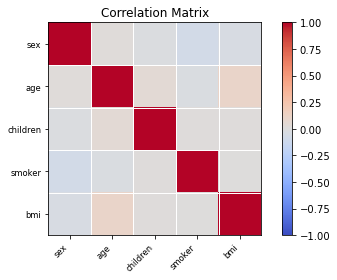

In [47]:
sm.graphics.plot_corr(corr_matrix, xnames=df.columns, normcolor=True, cmap='coolwarm')
plt.show()

## Как можно заметить, корреляция между регрессорами практически отсутствует. Наблюдается незначительная корреляция bmi и age. Рассмотрим ее подробнее

Подогнанная прямая


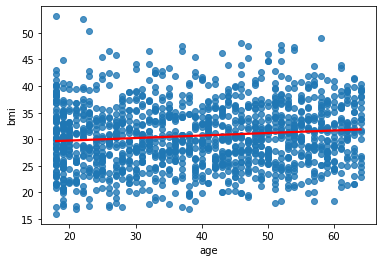

In [48]:
sns.regplot(data = df ,  y = 'bmi' ,  x = 'age' , order = 1, ci = None ,  line_kws = { "color":"r"}) 
print('Подогнанная прямая')

In [49]:
fitted = smf.ols(data=df, formula='bmi~age').fit()
fitted.params

Intercept    28.803889
age           0.047428
dtype: float64

In [50]:
print('R^2 = ', fitted.rsquared)

R^2 =  0.011940344097157163


## Вывод: чем человек старше, тем в среднем на 0.047 единиц больше его bmi. Однако, $R^2=0.012$ говорит о том, что возраст очень слабо объясняет изменение такого показателя, как bmi

## Проведем RESEТ-тест Рамсея финальной модели

$$
charges = \gamma_0 + \gamma_1*age^2+\gamma_2*bmi+\gamma_3*children+\gamma_4*smoker+\gamma_5*charges^2+\gamma_6*charges^3
$$

$$
H_0: \gamma_5=\gamma_6=0
$$
$$
H_1: \gamma_5^2+\gamma_6^2>0
$$
#### Гипотеза $H_0$ утверждает, что неучтенных переменных, которые описывают модель, нету
#### Гипотеза $H_1$ утверждает, что мы пропустили какие-либо регрессоры, которые также нужно было включить при оценке регрессии

In [51]:
df  =  pd.read_csv('https://raw.githubusercontent.com/PomoshnikovV/Econometrics_MGIMO/main/insurance.csv') 

In [52]:
df['smoker']=df.apply(lambda x: 1 if x['smoker'] == 'yes' else 0, axis=1)
df['sex']=df.apply(lambda x: 1 if x['sex'] == 'female' else 0, axis=1)
df['charges']=df['charges']

In [53]:
fitted = smf.ols(data=df, formula='charges~I(age**2)+bmi+children+smoker').fit()

In [54]:
pred = fitted.predict(exog = df , transform = True) 
df['pred'] = pred
df['pred2'] = pred**2
df['pred3'] = pred**3

In [55]:
fitted_ur = smf.ols(data=df, formula='charges~I(age**2)+bmi+children+smoker+pred2+pred3').fit()

In [56]:
f_test = fitted_ur.f_test( 'pred2=pred3=0' ) 
print('F_obs = ', f_test.fvalue)

F_obs =  [[61.01683893]]


In [57]:
print('F_crit = ', stats.f.ppf(1-0.01, 2, len(df)-7))

F_crit =  4.621140580486593


## Принимается гипотеза $H_1$
### Тест указывает на пропущенные регрессоры, которые не были учтены в модели. Возможно, стоило включить информацию о том, занимаются ли эти люди спортом, сколько зарабатывают, сколько работают в неделю, сколько спят и т.д.

## Следует также рассмотреть, не имеет ли место в данной модели автокорреляция

## 1) DW-тест

In [58]:
# знаменатель
res_sum = sum(fitted.resid**2)


In [59]:
# числитель
sum_resid = 0
for i in range(len(fitted.resid)-1):
    sum_resid+=(fitted.resid[i+1]-fitted.resid[i])**2

In [60]:
from statsmodels.stats.stattools import durbin_watson
#DW test
print('DW = ', durbin_watson(fitted.resid))

DW =  2.094467718502819


## Согласно таблице критических значений, при уровне значимости $\alpha=0.05$ полученное DW находится в области принятия гепотезы $H_1$, т.е. автокорреляция отсутствует

## 2) Тест Бройша-Годфри также указывает на отсутствие автокорреляции

In [61]:
print(dg.acorr_breusch_godfrey(fitted, nlags=3))

(6.992319135221485, 0.07214299113459373, 2.329008460668031, 0.07281643013240416)


In [62]:
Hi2  =  stats.chi2.ppf(1 - 0.05, 3) 
print('Hi2 = ', Hi2)

Hi2 =  7.814727903251179


## $n*R^2<\chi^2$, принимается гипотеза $H_1$, автокорреляция отсутствует

# Попробуем спрогнозировать траты на мед. страхование в Америке для трех различных людей:
1) Данила - 19 лет, не курит, нет детей, bmi = 23,8
\
2) Сергей - 40 лет, не курит, 2 детей, bmi = 31
\
3) Юрий - 30 лет, курит, нет детей, bmi = 37

In [73]:
new_df  =  pd.DataFrame({'age':[19 ,  40 ,  30],  'bmi':[23.8 ,  31,  37],  'children':[ 0 ,  2 ,  0 ],  'smoker':[0 , 0,  1]}) 
new_df

,age,bmi,children,smoker
0,19,23.8,0,0
1,40,31.0,2,0
2,30,37.0,0,1


In [74]:
fitted = smf.ols(data=df, formula='charges~I(age**2)+bmi+children+smoker').fit()

In [75]:
pred_3persons = fitted.predict(exog = new_df , transform = True)
new_df['pred$'] = pred_3persons
new_df

,age,bmi,children,smoker,pred$
0,19,23.8,0,0,1051.649462
1,40,31.0,2,0,8613.420117
2,30,37.0,0,1,30836.821364


## Итак, можно быть молодым и не иметь детей, но если куришь и плохо питаешься, то будешь много платить за медицинское страхование.
# Вывод: будь молодым, не кури и занимайся спортом!